In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances_argmin_min
import seaborn as sb
from yellowbrick.cluster import KElbowVisualizer
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import plotly.figure_factory as ff
from plotly.figure_factory import create_dendrogram
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Se cargan los datos. 
CollegeScoreCard=pd.read_csv('CollegeScorecard.csv', sep=',', encoding = 'utf-8')
# Cantidad de datos y número de variables
CollegeScoreCard.shape

C:\Users\Diego\AppData\Local\Temp\ipykernel_10448\1466162896.py:2: DtypeWarning: Columns (7,9,1427,1542,1561,1575) have mixed types. Specify dtype option on import or set low_memory=False.
  CollegeScoreCard=pd.read_csv('CollegeScorecard.csv', sep=',', encoding = 'utf-8')


(7804, 1725)

In [10]:
# data[data['INSTNM'].str.contains('niversity') & data["COSTT4_P"].notnull()]
# data[~data['INSTNM'].str.contains('niversity') & ~data['INSTNM'].str.contains('ollege') & ~data['INSTNM'].str.contains('nstitu')]
# data[data['INSTNM'].str.contains('niversity') | data['INSTNM'].str.contains('ollege') | data['INSTNM'].str.contains('nstitu') | data['INSTNM'].str.contains('chool') | data['INSTNM'].str.contains('enter')]
# data[~data['INSTNM'].str.contains('niversity') & ~data['INSTNM'].str.contains('ollege') & ~data['INSTNM'].str.contains('nstitu') & ~data['INSTNM'].str.contains('chool') & ~data['INSTNM'].str.contains('enter')]
# data[~data['INSTNM'].str.contains('niversity') & ~data['INSTNM'].str.contains('ollege') & ~data['INSTNM'].str.contains('nstitu') & ~data['INSTNM'].str.contains('chool') & ~data['INSTNM'].str.contains('enter') & ~data['INSTNM'].str.contains('cadem')]
# data[~data['INSTNM'].str.contains('niversity') & ~data['INSTNM'].str.contains('ollege') & ~data['INSTNM'].str.contains('nstitu') & ~data['INSTNM'].str.contains('chool') & ~data['INSTNM'].str.contains('enter') & ~data['INSTNM'].str.contains('cadem')  & ~data['INSTNM'].str.contains('CET')]
# data[data['INSTNM'].str.contains('niversity') | data['INSTNM'].str.contains('ollege') | data['INSTNM'].str.contains('nstitu') ]

In [11]:
def trans_variable_control(p):
    p_mod=''
    if p == 1:
        return "PUBLIC"
    elif p == 2:
        return "PRIVATE NONPROFIT"
    else:
        return "PRIVATE FOR-PROFIT"

In [12]:
# Depuracion y eleccion de variables
data=CollegeScoreCard[CollegeScoreCard["CURROPER"]!=0]
data=data[data["DISTANCEONLY"]!=1]
data=data[["INSTNM","CONTROL","COSTT4_A","COSTT4_P","PCTPELL","UG25abv","PCIP11","PCIP14","PCIP16","PCIP26","PCIP27","PCIP42","PCIP52"]]
data=data[data["COSTT4_A"].notnull() | data["COSTT4_P"].notnull()]
data=data[data['INSTNM'].str.contains('niversity') | data['INSTNM'].str.contains('ollege') | data['INSTNM'].str.contains('nstitu') ]
data=data[data["COSTT4_A"].notnull()]
data=data[data['UG25abv'].notnull()]
data=data.drop(['COSTT4_P'],axis=1)
data["CONTROL"]=data["CONTROL"].apply(trans_variable_control)
data=data.drop([2124])

Para la depuración inicial de la base de datos se tomaron en cuenta las instituciones que están operando actualmente y que sean solamente presenciales. Luego seleccionamos las variables que queremos tomar en cuenta en nuestro estudio:
- Nombre de institución.
- Tipo de institución (Public, private nonprofit, private for-profit).
- Costo anual de estudio.
- Porcentaje de estudiantes con beca "PELL".
- Porcentaje de estudiantes mayores a 25 años.
- Porcentaje de diplomas entregados en diferentes areas del conocimiento (Computer Science, Engineering, Linguistics, Biological Science, Mathematics, Psychology, Business)

Luego procedemos a revisar los valores nulos de las variables seleccionadas y se eliminan los valores nulos debido a que no tienen una gran representación en la base de datos.

In [13]:
data=data.rename(columns={'CONTROL': 'Tipo_de_Entidad','COSTT4_A': 'Costo_Anual_Estudio','PCTPELL': 'Becados_Pell','UG25abv': 'Estudiantes_Mayor_25','PCIP11': 'Computer_Science', 'PCIP14': 'Engineering','PCIP16': 'Linguistics', 'PCIP26': 'Biological_Science','PCIP27': 'Mathematics','PCIP42': 'Psychology','PCIP52': 'Business'})

In [14]:
data['Tipo_de_Entidad'].value_counts()

PUBLIC                1584
PRIVATE NONPROFIT     1259
PRIVATE FOR-PROFIT     904
Name: Tipo_de_Entidad, dtype: int64

In [15]:
#Dymmys
data= pd.get_dummies(data, columns=['Tipo_de_Entidad'])

In [16]:
data.head()

,INSTNM,Costo_Anual_Estudio,Becados_Pell,Estudiantes_Mayor_25,Computer_Science,Engineering,Linguistics,Biological_Science,Mathematics,Psychology,Business,Tipo_de_Entidad_PRIVATE FOR-PROFIT,Tipo_de_Entidad_PRIVATE NONPROFIT,Tipo_de_Entidad_PUBLIC
0,Alabama A & M University,18888.0,0.7115,0.1049,0.0348,0.1175,0.0000,0.1026,0.0199,0.0579,0.1457,0,0,1
1,University of Alabama at Birmingham,19990.0,0.3505,0.2422,0.0099,0.0632,0.0090,0.0619,0.0135,0.0840,0.1765,0,0,1
2,Amridge University,12300.0,0.6839,0.8540,0.0411,0.0000,0.0000,0.0000,0.0000,0.0000,0.0685,0,1,0
3,University of Alabama in Huntsville,20306.0,0.3281,0.2640,0.0273,0.2566,0.0173,0.0855,0.0218,0.0218,0.2247,0,0,1
4,Alabama State University,17400.0,0.8265,0.1270,0.0450,0.0000,0.0000,0.1033,0.0183,0.0617,0.1067,0,0,1


In [17]:
data.describe()

,Costo_Anual_Estudio,Becados_Pell,Estudiantes_Mayor_25,Computer_Science,Engineering,Linguistics,Biological_Science,Mathematics,Psychology,Business,Tipo_de_Entidad_PRIVATE FOR-PROFIT,Tipo_de_Entidad_PRIVATE NONPROFIT,Tipo_de_Entidad_PUBLIC
count,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000
mean,24340.439018,0.485286,0.361186,0.043060,0.012511,0.004729,0.024639,0.005057,0.031553,0.149910,0.241260,0.336002,0.422738
std,12373.111799,0.207783,0.236188,0.095056,0.052986,0.013116,0.044774,0.010082,0.061696,0.158297,0.427905,0.472403,0.494060
min,4157.000000,0.000000,0.000500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13794.500000,0.328050,0.169550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045050,0.000000,0.000000,0.000000
50%,22646.000000,0.453800,0.336200,0.015000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118600,0.000000,0.000000,0.000000
75%,30694.500000,0.639500,0.527800,0.038350,0.000000,0.003800,0.038050,0.006850,0.051950,0.195900,0.000000,1.000000,1.000000
max,74473.000000,1.000000,1.000000,1.000000,0.914300,0.375600,1.000000,0.125000,0.882400,1.000000,1.000000,1.000000,1.000000


Se normaliza la base de datos convirtiendo las variables categóricas en "dummies" para poder usarlas en el análisis.

In [18]:
university=data[data['INSTNM'].str.contains('niversity')]
college=data[data['INSTNM'].str.contains('ollege')]
institution=data[data['INSTNM'].str.contains('nstitu') ]

In [19]:
nombresUniversity=university['INSTNM']
university=university.drop(['INSTNM'],axis=1)
nombresCollege=college['INSTNM']
college=college.drop(['INSTNM'],axis=1)
nombresInstitution=institution['INSTNM']
institution=institution.drop(['INSTNM'],axis=1)

Dividimos las bases de datos en 3 grupos:
- University
- College
- Institute
Luego eliminamos la columna de los nombres y procedemos a realizar los clusters.

In [20]:
# copy the data
norm_university = university.copy()
  
# apply normalization techniques
column = 'Costo_Anual_Estudio'
norm_university[column] = MinMaxScaler().fit_transform(np.array(norm_university[column]).reshape(-1,1))

In [21]:
# copy the data
norm_college = college.copy()
  
# apply normalization techniques
column = 'Costo_Anual_Estudio'
norm_college[column] = MinMaxScaler().fit_transform(np.array(norm_college[column]).reshape(-1,1))

In [22]:
# copy the data
norm_institution = institution.copy()
  
# apply normalization techniques
column = 'Costo_Anual_Estudio'
norm_institution[column] = MinMaxScaler().fit_transform(np.array(norm_institution[column]).reshape(-1,1))

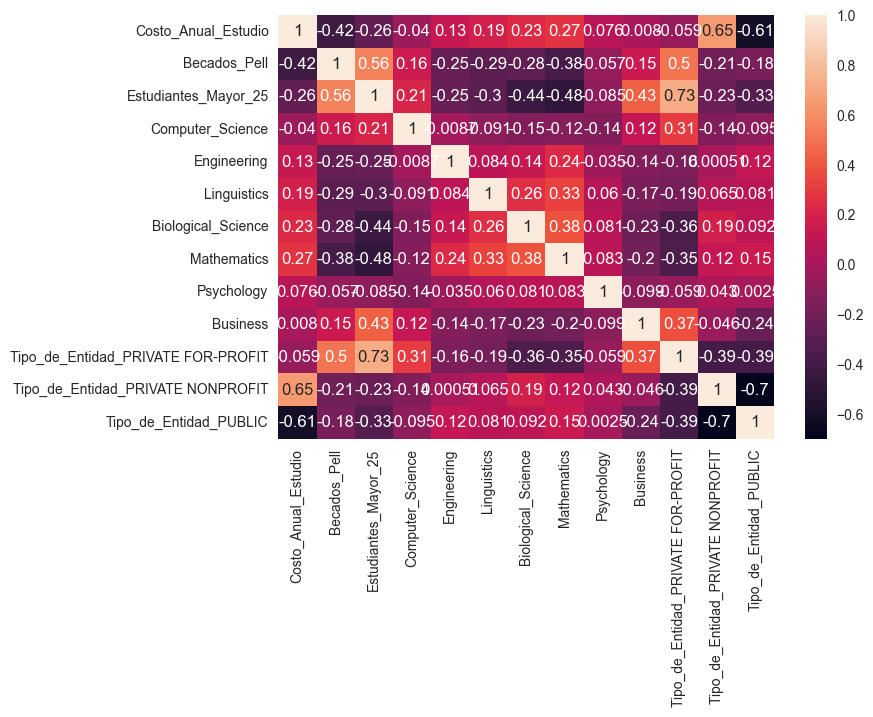

In [23]:
UnicorrMatrix = norm_university.corr()
sb.heatmap(UnicorrMatrix, annot=True)
plt.show()

Realizamos una matriz de correlación de las variables en la base de datos "University". De ésta matriz podemos destacar que las variables más correlacionadas son los estudiantes mayores de 25 años con las universidades privadas con animo de lucro con un porcentaje de correlación de 0.73.

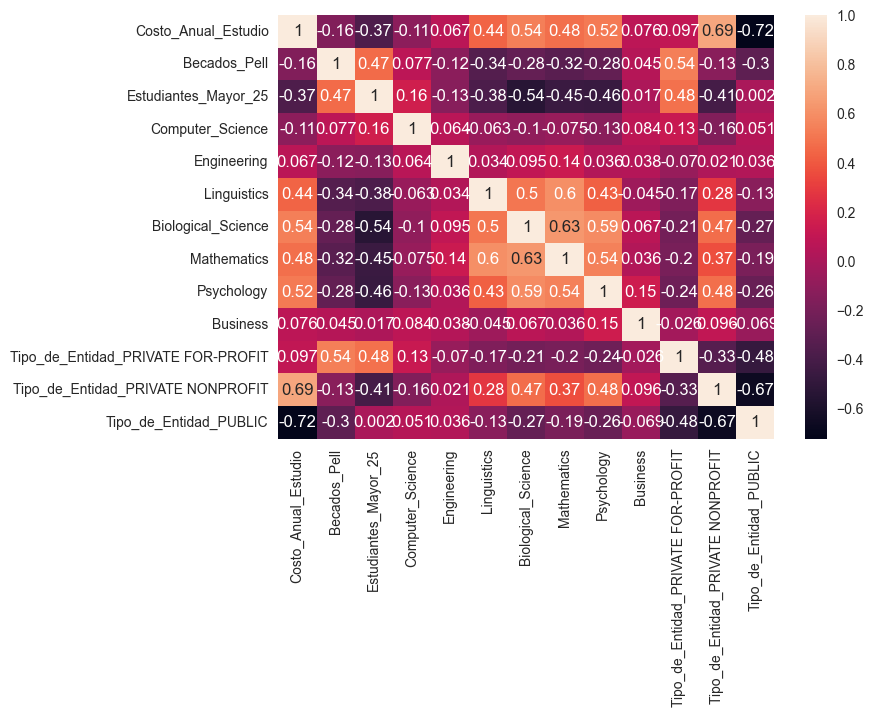

In [24]:
CollcorrMatrix = norm_college.corr()
sb.heatmap(CollcorrMatrix, annot=True)
plt.show()

Realizamos una matriz de correlación de la base de datos "college" en donde podemos destacar la correación entre "college private nonprofit" con el costo anual de estudio, la cual tiene un valor de 0.69.

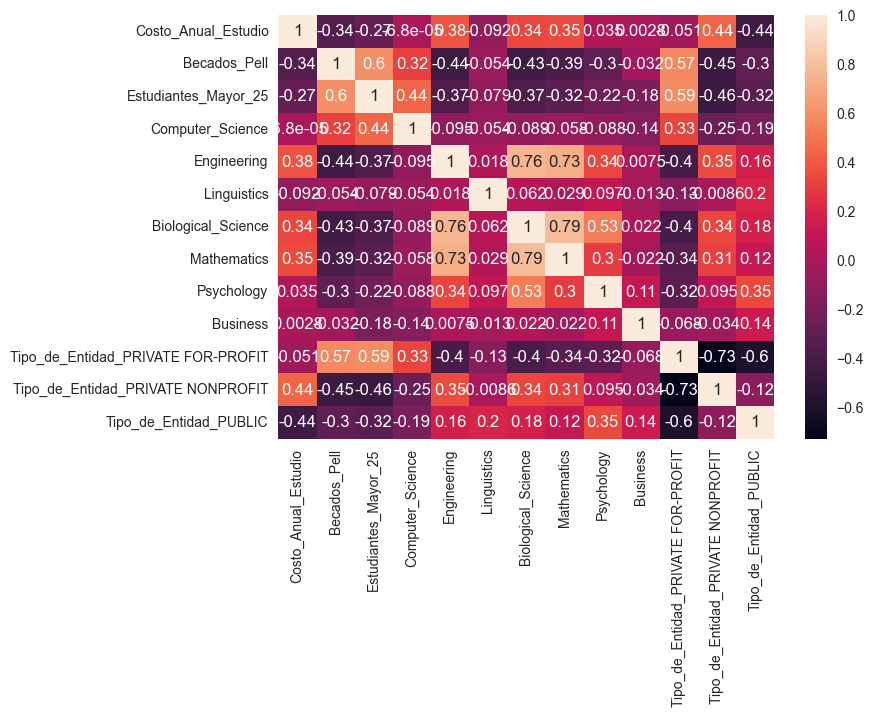

In [25]:
InstcorrMatrix = norm_institution.corr()
sb.heatmap(InstcorrMatrix, annot=True)
plt.show()

Por último realizamos la matriz de correlación de la base de datos "Institution" en la que podemos observar que la correlación mas significativa es la que hay entre los diplomas entregados en Ciencias Biológicas e Ingeniería que tiene un valor de 0.76.

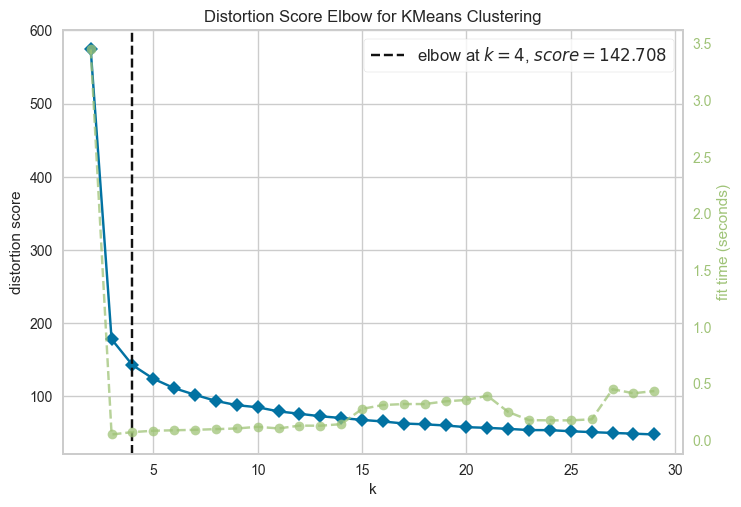

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
modelUni = KMeans()
visualizer = KElbowVisualizer(modelUni, k=(2,30), timings= True)
Unifit=norm_university.sample(int(len(norm_university)*1))
visualizer.fit(Unifit)        
visualizer.show() 

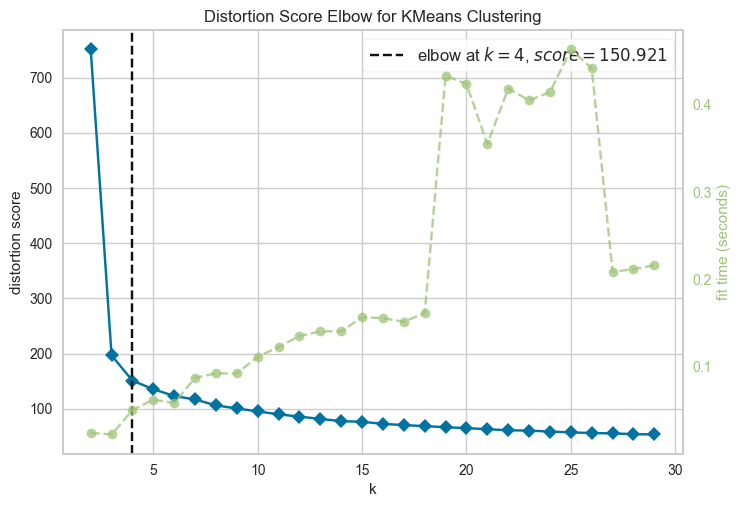

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
modelColl = KMeans()
visualizer = KElbowVisualizer(modelColl, k=(2,30), timings= True)
Collfit=norm_college.sample(int(len(norm_college)*1))
visualizer.fit(Collfit)        
visualizer.show() 

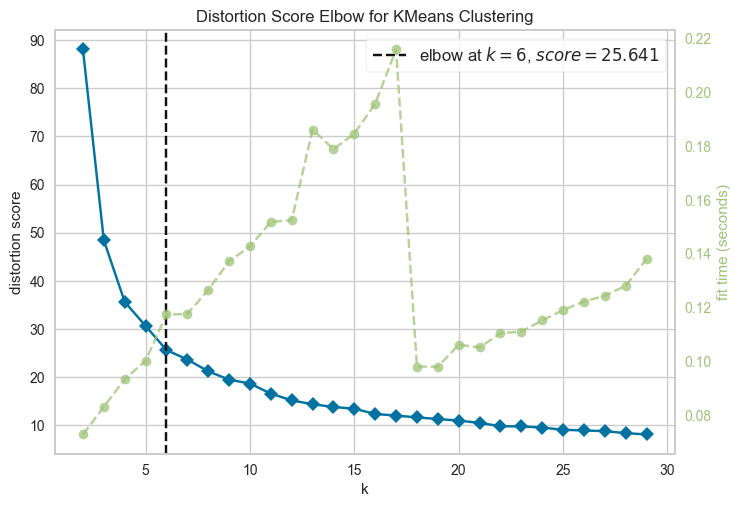

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
modelInst = KMeans()
visualizer = KElbowVisualizer(modelInst, k=(2,30), timings= True)
Instfit=norm_institution.sample(int(len(norm_institution)*1))
visualizer.fit(Instfit)        
visualizer.show() 

Realizamos la prueba de codo para conocer el número óptimo de clusters para cada base de datos en la que quedamos con 4 clusters para university y college y 6 clusters para Institution.

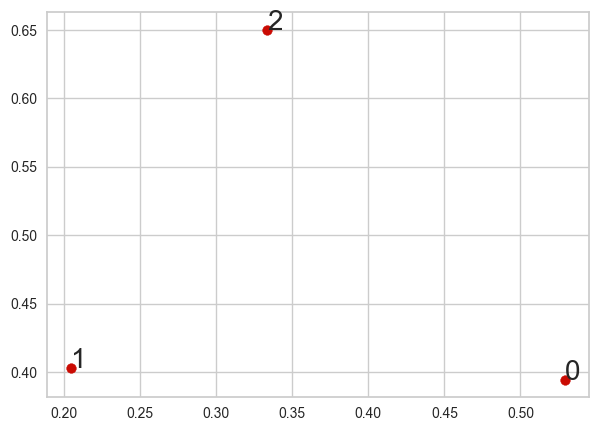

In [29]:
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(Unifit)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_
fig, ax = plt.subplots(figsize=(7, 5))

plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', marker='o')

for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [30]:
university['Nombre Universidad']=nombresUniversity
university['Clasificacion']=labels_2D
university['Clasificacion'].value_counts()

1    556
0    556
2    239
Name: Clasificacion, dtype: int64

In [31]:
grupo0=university[university['Clasificacion']==0]
grupo1=university[university['Clasificacion']==1]
grupo2=university[university['Clasificacion']==2]
# grupo3=university[university['Clasificacion']==3]

In [32]:
df=pd.DataFrame()
df['grupo0']=grupo0.median()
df['grupo1']=grupo1.median()
df['grupo2']=grupo2.median()
# df['grupo3']=grupo3.median()
df

C:\Users\Diego\AppData\Local\Temp\ipykernel_10448\3900488160.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['grupo0']=grupo0.median()
C:\Users\Diego\AppData\Local\Temp\ipykernel_10448\3900488160.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['grupo1']=grupo1.median()
C:\Users\Diego\AppData\Local\Temp\ipykernel_10448\3900488160.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['grupo2']=grupo2.median()


,grupo0,grupo1,grupo2
Costo_Anual_Estudio,24487.50000,23265.50000,24956.0000
Becados_Pell,0.41935,0.40220,0.4228
Estudiantes_Mayor_25,0.22580,0.23445,0.2387
Computer_Science,0.01610,0.01410,0.0135
Engineering,0.00000,0.00000,0.0000
Linguistics,0.00000,0.00000,0.0015
Biological_Science,0.03300,0.03265,0.0343
Mathematics,0.00425,0.00435,0.0064
Psychology,0.04715,0.04305,0.0470
Business,0.18195,0.17245,0.1790


In [34]:
# dict for the dataframes and their names
dfs = {"grupo0" : grupo0, "grupo1": grupo1, "grupo2" : grupo2}

# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Box(y = dfs[i]["Estudiantes_Mayor_25"], 
                                   name = i))
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

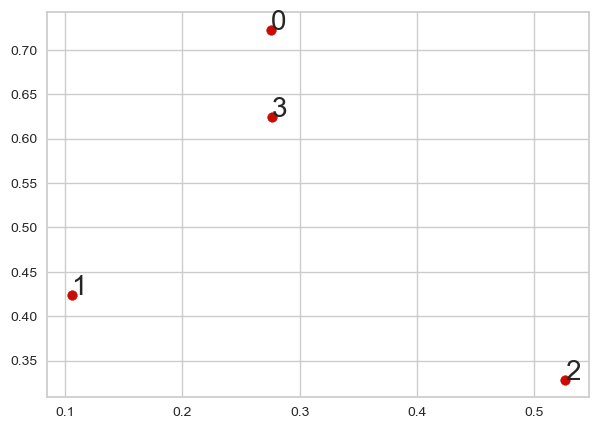

In [ ]:
kmeans_model_2D = KMeans(n_clusters=4, max_iter=1000).fit(Collfit)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_
fig, ax = plt.subplots(figsize=(7, 5))

plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', marker='o')

for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [ ]:
college['Nombre Collage']=nombresCollege
college['Clasificacion']=labels_2D
college['Clasificacion'].value_counts()

1    1023
0     403
2     391
3     275
Name: Clasificacion, dtype: int64

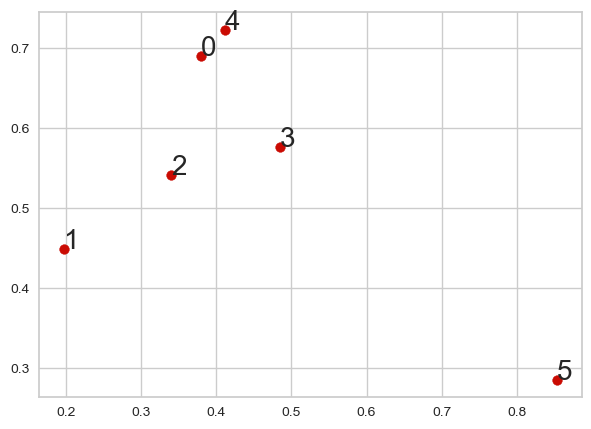

In [ ]:
kmeans_model_2D = KMeans(n_clusters=6, max_iter=1000).fit(Instfit)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_
fig, ax = plt.subplots(figsize=(7, 5))

plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', marker='o')

for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [ ]:
institution['Nombre Collage']=nombresInstitution
institution['Clasificacion']=labels_2D
institution['Clasificacion'].value_counts()

4    125
0     90
3     66
1     31
5     23
2     21
Name: Clasificacion, dtype: int64

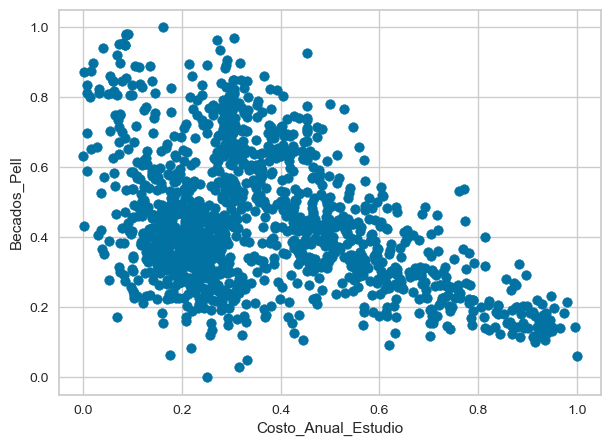

In [ ]:
fig = plt.subplots(figsize=(7, 5))

plt.scatter(norm_university['Costo_Anual_Estudio'], norm_university['Becados_Pell'])

plt.xlabel('Costo_Anual_Estudio')
plt.ylabel('Becados_Pell')

plt.show()

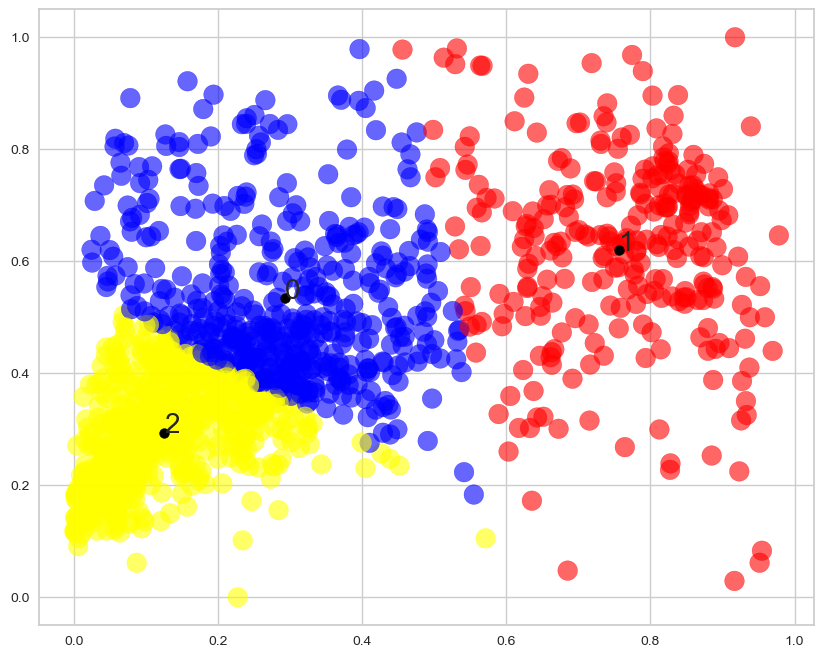

In [ ]:
df_2D = norm_university[['Estudiantes_Mayor_25', 'Becados_Pell']]
df_2D = np.array(df_2D)
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(df_2D)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_

colors_k_means = ['blue','green','red','yellow']
 
fig = plt.figure(figsize=(10, 8))
plt.scatter(df_2D[:, 0], df_2D[:, 1], c=labels_2D, s=200,
            cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.6)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='black', s=200, marker='.')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [ ]:
df_2D = norm_college[['Estudiantes_Mayor_25', 'Becados_Pell']]
df_2D = np.array(df_2D)
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(df_2D)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_

colors_k_means = ['blue','green','red']
 
fig = plt.figure(figsize=(10, 8))
plt.scatter(df_2D[:, 0], df_2D[:, 1], c=labels_2D, s=200,
            cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.6)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='black', s=200, marker='.')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [ ]:
df_2D = norm_institution[['Estudiantes_Mayor_25', 'Becados_Pell']]
df_2D = np.array(df_2D)
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(df_2D)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_

colors_k_means = ['blue','green','red']
 
fig = plt.figure(figsize=(10, 8))
plt.scatter(df_2D[:, 0], df_2D[:, 1], c=labels_2D, s=200,
            cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.6)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='black', s=200, marker='.')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)